# Successful games determination

1. [Data description and libraries import](#descriptionid)
2. [Data preprocessing](#preprocid)
    1. [Data types and NaN values](#typesid)
    2. [Handling gaps and duplicates](#nansduplicatesid)
3. [EDA](#analysisifd)
4. [User profile](#customerid)
    1. [Popular platforms](#platformsid)
    2. [popular genres](#genresid)
    3. [ERSB rating](#ersbid)
5. [Hypothesis testing](#hypothesisid)
6. [Conclusions](#conclusionid)

Data for 2016 was taken for the project. 

**Project aim:** to analyse the data and determine potentially successful games in order to plan advertising campaigns. 

## Data description and libraries import<a id='descriptionid'></a>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from math import factorial

In [2]:
import os

Let's load and open the dataset:

In [3]:
path = 'C:/Python/datasets/'
if os.path.exists(path):
    df = pd.read_csv(path + 'games.csv')
else:
    df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Table columns: 

* Name — name of a game;
* Platform — platform; 
* Year_of_Release — year of release;
* Genre — game genre;
* NA_sales — sales in North America, million copies;
* EU_sales — sales in Europe, million copies;
* JP_sales — sales in Japan, million copies;
* Other_sales — sales in other regions, million copies;
* Critic_Score — critics score, max. 100;
* User_Score — users score, max. 100;
* Rating — ESRB rating (Entertainment Software Rating Board). This rating system determines game rating and gives an age category to the game.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


There are a lot of missing values observed in columns with scores (users and critics), as well as in rating column. They can be related to the small amount of nformation available in the data source. Their change in our case is unreasonable. 

Also, there are missing values in the column 'year_of_release'. Taking into consideration that those values are not that many, substitution/filling these values might be posible after the analysis.

## Data preprocessing<a id='preprocid'></a>
### Data types. NaN values.<a id='typesid'></a>

First, it's better to change the names of the columns, converting their content to a lowercase:

In [5]:
d = {'Name':'name', 'Platform':'platform', 'Year_of_Release':'year_of_release', 'Genre':'genre', 'NA_sales':'na_sales', 
    'EU_sales':'eu_sales', 'JP_sales':'jp_sales', 'Other_sales':'other_sales', 'Critic_Score':'critic_score',
    'User_Score':'user_score', 'Rating':'rating_age'}
df.rename(columns = d, inplace = True)

Then let's examine data types. 

In [6]:
df['na_sales'].max()

41.36

For decreasing a bit memory usage, let's convert float64 into float16.

In [7]:
df['na_sales'] = df['na_sales'].astype('float16')
df['eu_sales'] = df['eu_sales'].astype('float16')
df['jp_sales'] = df['jp_sales'].astype('float16')
df['other_sales'] = df['other_sales'].astype('float16')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float16
 5   eu_sales         16715 non-null  float16
 6   jp_sales         16715 non-null  float16
 7   other_sales      16715 non-null  float16
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating_age       9949 non-null   object 
dtypes: float16(4), float64(2), object(5)
memory usage: 1.0+ MB


Year_of_release columns has float type due to the presence of NaN values.

### Handling gaps and duplicates<a id='nansduplicatesid'></a>
 

There are some missing values. Let's see if there are some lines that contain missing names:

In [9]:
df.isna().query('name == True')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_age
659,True,False,False,True,False,False,False,False,True,True,True
14244,True,False,False,True,False,False,False,False,True,True,True


Substitute them with "unknown":

In [10]:
df['name'] = df['name'].fillna('unknown')
df.loc[14244, 'name']

'unknown'

User score NaN values:

In [11]:
df['user_score'].isna().sum()

6701

*initially the number of missing values in user_score - 6701.

In [12]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Most probably, tbd - "to be determined or decided or declared". Thus values might be substituted with NaN:

In [13]:
def to_nan(row):
    if row['user_score'] == 'tbd':
        new = np.nan
    else:
        new = row['user_score']
    return new
df['new'] = df.apply(to_nan, axis = 1)
df['user_score'] = df['new']
del df['new']
df.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_age


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float16
 5   eu_sales         16715 non-null  float16
 6   jp_sales         16715 non-null  float16
 7   other_sales      16715 non-null  float16
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   object 
 10  rating_age       9949 non-null   object 
dtypes: float16(4), float64(2), object(5)
memory usage: 1.0+ MB


Let's see if there are duplicates for the games names. First, will change all the columns content to the lowercase:

In [15]:
df['platform'] = df['platform'].str.lower()
df['name'] = df['name'].str.lower()

In [16]:
len(df['name'].unique())

11560

Very big amount of duplicated names. It doesn't mean it is a mistake and can be related to the multiple platforms of the same game etc. 

In [17]:
df_names = df.pivot_table(index = 'name', values = 'platform', aggfunc = 'count').reset_index()
df_names.sort_values(by = 'platform', ascending = False).head()

,name,platform
6631,need for speed: most wanted,12
5422,madden nfl 07,9
5211,lego marvel super heroes,9
7791,ratatouille,9
3114,fifa 14,9


Also, let's see on the date of release and count number of platforms for each game and platfor:

In [18]:
df.query('name == "need for speed: most wanted"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_age
253,need for speed: most wanted,ps2,2005.0,Racing,2.029297,1.790039,0.080017,0.469971,82.0,9.1,T
523,need for speed: most wanted,ps3,2012.0,Racing,0.709961,1.459961,0.059998,0.580078,NaN,NaN,NaN
1190,need for speed: most wanted,x360,2012.0,Racing,0.620117,0.779785,0.010002,0.150024,83.0,8.5,T
1591,need for speed: most wanted,x360,2005.0,Racing,1.000000,0.130005,0.020004,0.099976,83.0,8.5,T
1998,need for speed: most wanted,xb,2005.0,Racing,0.529785,0.459961,0.000000,0.049988,83.0,8.8,T
2048,need for speed: most wanted,psv,2012.0,Racing,0.330078,0.449951,0.010002,0.219971,NaN,NaN,NaN
3581,need for speed: most wanted,gc,2005.0,Racing,0.429932,0.109985,0.000000,0.020004,80.0,9.1,T
5972,need for speed: most wanted,pc,2005.0,Racing,0.020004,0.229980,0.000000,0.040009,82.0,8.5,T
6273,need for speed: most wanted,wiiu,2013.0,Racing,0.130005,0.119995,0.000000,0.020004,NaN,NaN,NaN
6410,need for speed: most wanted,ds,2005.0,Racing,0.239990,0.010002,0.000000,0.020004,45.0,6.1,E


In [19]:
df.query('name == "madden nfl 07"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_age
241,madden nfl 07,ps2,2006.0,Sports,3.630859,0.239990,0.010002,0.609863,84.0,8.2,E
972,madden nfl 07,x360,2006.0,Sports,1.660156,0.000000,0.010002,0.130005,80.0,6,E
2035,madden nfl 07,xb,2006.0,Sports,0.970215,0.029999,0.000000,0.029999,83.0,8.7,E
2479,madden nfl 07,psp,NaN,Sports,0.770020,0.029999,0.000000,0.040009,78.0,6.6,E
3229,madden nfl 07,gc,2006.0,Sports,0.479980,0.130005,0.000000,0.020004,82.0,9.2,E
3838,madden nfl 07,ps3,2006.0,Sports,0.469971,0.000000,0.010002,0.040009,76.0,4.2,E
4006,madden nfl 07,wii,2006.0,Sports,0.459961,0.000000,0.000000,0.040009,81.0,8,E
7372,madden nfl 07,ds,2006.0,Sports,0.199951,0.000000,0.000000,0.020004,70.0,6.5,E
14889,madden nfl 07,gba,2006.0,Sports,0.020004,0.010002,0.000000,0.000000,68.0,9.3,E


There are various release years for the same platforms, thus, we can not fill NaN values in the 'year_of_release' column with the year for the specific platform. 

Let's count the total number of games which have more than one platform:

In [20]:
len(df_names.query('platform > 1'))

2806

In [21]:
#games with more than one platform, list:
pl_mult = df_names.query('platform > 1')['name'].unique()
pl_mult

array([" frozen: olaf's quest", '007: quantum of solace',
       '007: the world is not enough', ..., 'zumba fitness',
       'zumba fitness core', 'zumba fitness: world party'], dtype=object)

In [22]:
print('Total unique platform types in the table:', len(df['platform'].unique()))
df['platform'].unique()

Total unique platform types in the table: 31


array(['wii', 'nes', 'gb', 'ds', 'x360', 'ps3', 'ps2', 'snes', 'gba',
       'ps4', '3ds', 'n64', 'ps', 'xb', 'pc', '2600', 'psp', 'xone',
       'wiiu', 'gc', 'gen', 'dc', 'psv', 'sat', 'scd', 'ws', 'ng', 'tg16',
       '3do', 'gg', 'pcfx'], dtype=object)

It's good to notice, that there are no typo mistakes in platforms names.

Let's check if there are duplicates 'game - platform'. 


In [23]:
#Table containint only data about games having many platforms:
duplicated_names = (df.query('name in @pl_mult')
                    .pivot_table(index = ['name', 'platform', 'year_of_release', 'genre', 'rating_age'], 
                                                                  values = ['user_score', 'na_sales', 'eu_sales', 
                                                                            'jp_sales', 'other_sales', 'critic_score'], 
                                                                  aggfunc = 'mean').reset_index()
                   )
duplicated_names.head()

,name,platform,year_of_release,genre,rating_age,critic_score,eu_sales,jp_sales,na_sales,other_sales
0,007: quantum of solace,ds,2008.0,Action,T,65.0,0.010002,0.000000,0.109985,0.010002
1,007: quantum of solace,pc,2008.0,Action,T,70.0,0.010002,0.000000,0.010002,0.000000
2,007: quantum of solace,ps3,2008.0,Action,T,65.0,0.509766,0.020004,0.429932,0.189941
3,007: quantum of solace,wii,2008.0,Action,T,54.0,0.280029,0.010002,0.290039,0.070007
4,007: quantum of solace,x360,2008.0,Action,T,65.0,0.509766,0.010002,0.819824,0.140015


In [24]:
print('Its length:')
len(duplicated_names)

Its length:


5984

After grouping, some lines were merged (lines for which the name, platform, year of release, genre, age category are the same. In contrast, the length of not groupped df with games having multiple platforms is:

In [25]:
len(df.query('name in @pl_mult'))

7961

Which means following number of lines were lost during the groupping:

In [26]:
len(df.query('name in @pl_mult')) - len(duplicated_names)

1977

These values are duplicates. Thus, we can take an average of the ratings and sales for these games. First let's delete a data slice containing games from duplicated_names table, then add all the table to df, so getting the data, where the duplicates are merged (mean value).

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float16
 5   eu_sales         16715 non-null  float16
 6   jp_sales         16715 non-null  float16
 7   other_sales      16715 non-null  float16
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   object 
 10  rating_age       9949 non-null   object 
dtypes: float16(4), float64(2), object(5)
memory usage: 1.0+ MB


In [28]:
df = df.query('name not in @pl_mult')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8754 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             8754 non-null   object 
 1   platform         8754 non-null   object 
 2   year_of_release  8631 non-null   float64
 3   genre            8754 non-null   object 
 4   na_sales         8754 non-null   float16
 5   eu_sales         8754 non-null   float16
 6   jp_sales         8754 non-null   float16
 7   other_sales      8754 non-null   float16
 8   critic_score     3070 non-null   float64
 9   user_score       2717 non-null   object 
 10  rating_age       3841 non-null   object 
dtypes: float16(4), float64(2), object(5)
memory usage: 615.5+ KB


In [29]:
7961 + 8754 


16715

In [30]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating_age'],
      dtype='object')

In [31]:
duplicated_names.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'rating_age',
       'critic_score', 'eu_sales', 'jp_sales', 'na_sales', 'other_sales'],
      dtype='object')

Columns order:

In [32]:
duplicated_names = duplicated_names.reindex(columns = ['name', 'platform', 'year_of_release', 
                                                       'genre', 'na_sales', 'eu_sales','jp_sales', 
                                                       'other_sales', 'critic_score', 'user_score', 'rating_age'])

In [33]:
display(df.info())
duplicated_names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8754 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             8754 non-null   object 
 1   platform         8754 non-null   object 
 2   year_of_release  8631 non-null   float64
 3   genre            8754 non-null   object 
 4   na_sales         8754 non-null   float16
 5   eu_sales         8754 non-null   float16
 6   jp_sales         8754 non-null   float16
 7   other_sales      8754 non-null   float16
 8   critic_score     3070 non-null   float64
 9   user_score       2717 non-null   object 
 10  rating_age       3841 non-null   object 
dtypes: float16(4), float64(2), object(5)
memory usage: 615.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5984 entries, 0 to 5983
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             5984 non-null   object 
 1   platform         5984 non-null   object 
 2   year_of_release  5984 non-null   float64
 3   genre            5984 non-null   object 
 4   na_sales         5984 non-null   float16
 5   eu_sales         5984 non-null   float16
 6   jp_sales         5984 non-null   float16
 7   other_sales      5984 non-null   float16
 8   critic_score     4921 non-null   float64
 9   user_score       0 non-null      float64
 10  rating_age       5984 non-null   object 
dtypes: float16(4), float64(3), object(4)
memory usage: 374.1+ KB


In [34]:
df.reset_index(drop=True, inplace=True)
duplicated_names.reset_index(drop=True, inplace=True)
df = pd.concat([duplicated_names, df], axis=0, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14738 entries, 0 to 14737
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             14738 non-null  object 
 1   platform         14738 non-null  object 
 2   year_of_release  14615 non-null  float64
 3   genre            14738 non-null  object 
 4   na_sales         14738 non-null  float16
 5   eu_sales         14738 non-null  float16
 6   jp_sales         14738 non-null  float16
 7   other_sales      14738 non-null  float16
 8   critic_score     7991 non-null   float64
 9   user_score       2717 non-null   object 
 10  rating_age       9825 non-null   object 
dtypes: float16(4), float64(2), object(5)
memory usage: 921.2+ KB


**Now we got a table which does not contain duplicates in names and platforms.**

Missing score values are not reasonable to substitute because they might carry a semantic load.

In [35]:
# a check:
df.duplicated(['name', 'platform', 'year_of_release', 'genre']).sum()

0

Some games have different years of release for different platforms, thus we can not fill the missing values in that column. 


Finally, let's calculate the total sales in all regions:

In [36]:

df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_age,total_sales
0,007: quantum of solace,ds,2008.0,Action,0.109985,0.010002,0.000000,0.010002,65.0,NaN,T,0.130005
1,007: quantum of solace,pc,2008.0,Action,0.010002,0.010002,0.000000,0.000000,70.0,NaN,T,0.020004
2,007: quantum of solace,ps3,2008.0,Action,0.429932,0.509766,0.020004,0.189941,65.0,NaN,T,1.149414
3,007: quantum of solace,wii,2008.0,Action,0.290039,0.280029,0.010002,0.070007,54.0,NaN,T,0.649902
4,007: quantum of solace,x360,2008.0,Action,0.819824,0.509766,0.010002,0.140015,65.0,NaN,T,1.479492


## EDA<a id='analysisid'></a>


Let's see how many games were released in different years and whether the data is important for all periods: 

In [37]:
df_years = df.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
df_years.sort_values(by = 'name')

,name
year_of_release,
1980.0,4
1988.0,9
1984.0,10
1989.0,10
1985.0,11
1990.0,13
1983.0,13
1987.0,14
1986.0,18


In [38]:
df_years.sort_values(by = 'year_of_release')

,name
year_of_release,
1980.0,4
1981.0,42
1982.0,30
1983.0,13
1984.0,10
1985.0,11
1986.0,18
1987.0,14
1988.0,9


It can be seen that before 1993 less than 50 games were released per year. This sample size is not enough for making reliable conclusions, so we will focus on the information after 1993. First, let's see the percent of dropped data:

In [39]:
print('Games released before 1993: {:.2%}'.format(len(df[df['year_of_release'] < 1993])/len(df)))

Games released before 1993: 1.61%


In [40]:
df = df.query('year_of_release >= 1993')

Next, let's calculate total sales per platform for all the period:

In [41]:
df_platforms_sales = df.pivot_table(index = 'platform', values = ['total_sales'], aggfunc = 'sum').reset_index()
df_platforms_sales.sort_values(by = 'total_sales')

,platform,total_sales
12,pcfx,0.029999
0,3do,0.099976
22,tg16,0.160034
25,ws,0.660156
10,ng,1.110352
20,scd,1.860352
9,nes,3.720703
7,gen,4.671875
2,dc,13.328125
19,sat,25.796875


In [42]:
print('Platforms with more than 100 million sales:') 
df_platforms_sales.sort_values(by = 'total_sales', ascending = False).query('total_sales > 100')['platform'].reset_index(drop = True)

Platforms with more than 100 million sales:


0      ps2
1     x360
2      ps3
3      wii
4       ds
5       ps
6      gba
7      psp
8      ps4
9       xb
10     3ds
11      pc
12      gc
13     n64
14      gb
15    xone
Name: platform, dtype: object

Now we will analyse the date on platforms and years to see, if there is any connection between number of sales in different platforms. For this let's take platforms with total sales more than 100 millions.

In [43]:
pl = df_platforms_sales.query('total_sales > 100')['platform'].unique()

In [44]:
df_platform_year = df.query('platform in @pl')

In [45]:
df_platform_year.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_age,total_sales
0,007: quantum of solace,ds,2008.0,Action,0.109985,0.010002,0.000000,0.010002,65.0,NaN,T,0.130005
1,007: quantum of solace,pc,2008.0,Action,0.010002,0.010002,0.000000,0.000000,70.0,NaN,T,0.020004
2,007: quantum of solace,ps3,2008.0,Action,0.429932,0.509766,0.020004,0.189941,65.0,NaN,T,1.149414
3,007: quantum of solace,wii,2008.0,Action,0.290039,0.280029,0.010002,0.070007,54.0,NaN,T,0.649902
4,007: quantum of solace,x360,2008.0,Action,0.819824,0.509766,0.010002,0.140015,65.0,NaN,T,1.479492


In [46]:
df_platform_gr = df_platform_year.pivot_table(index = ['platform', 'year_of_release'], values = 'total_sales', 
                                                aggfunc = 'sum').reset_index()
df_platform_gr.head()

,platform,year_of_release,total_sales
0,3ds,2011.0,54.750000
1,3ds,2012.0,48.375000
2,3ds,2013.0,50.156250
3,3ds,2014.0,34.406250
4,3ds,2015.0,26.921875


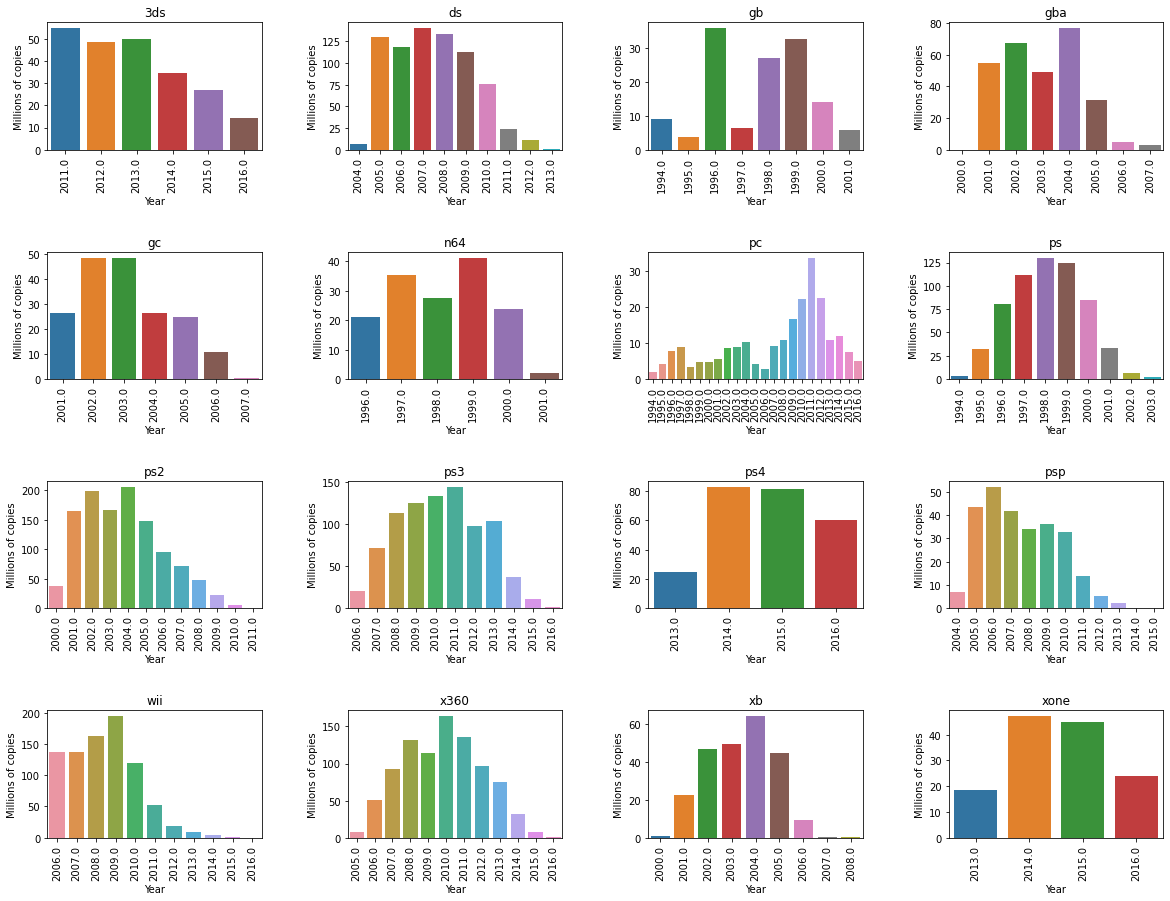

<Figure size 432x288 with 0 Axes>

In [47]:

a = 4  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.8, wspace=0.4)


for name in df_platform_gr['platform'].unique():
    plt.subplot(a, b, c)
    plt.title(name)
    ax = sns.barplot(x="year_of_release", y="total_sales",
                        data=df_platform_gr[df_platform_gr['platform'] == name])
    ax.set_xlabel('Year')
    ax.set_ylabel('million copies')
    plt.xticks(rotation=90)
    c = c + 1

plt.show()
plt.tight_layout()

In [48]:
old_games = (df_platform_gr.pivot_table(index = 'platform', values = 'year_of_release', aggfunc = 'max')
             .reset_index().query('year_of_release < 2016')['platform'].unique()
            )
games = (df_platform_gr.query('platform in @old_games')
         .pivot_table(index = 'platform', values = 'year_of_release', aggfunc = 'count')
        )
games.median()

year_of_release    9.0
dtype: float64

Based on the graphs and pivot table, we can see that, on average, "appear-disappear' cycle for platforms takes 9 years. The peak sales depend on a platform and, probably, on an advertising campaign. On average, the peak in sales comes in 1-5 years, therefore, we are interested in the period over the last 5 years, that we will use for our analysis.

Let's take the data starting from 2010:

In [49]:
df_actual = df.query('year_of_release >= 2010')
df_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_age,total_sales
13,2010 fifa world cup south africa,ps3,2010.0,Sports,0.300049,0.640137,0.070007,0.219971,82.0,NaN,E,1.230469
14,2010 fifa world cup south africa,psp,2010.0,Sports,0.090027,0.219971,0.029999,0.119995,69.0,NaN,E,0.459961
15,2010 fifa world cup south africa,wii,2010.0,Sports,0.229980,0.150024,0.010002,0.040009,70.0,NaN,E,0.429932
16,2010 fifa world cup south africa,x360,2010.0,Sports,0.320068,0.419922,0.020004,0.090027,83.0,NaN,E,0.850098
17,2014 fifa world cup brazil,ps3,2014.0,Sports,0.150024,0.360107,0.010002,0.090027,73.0,NaN,E,0.609863


In [50]:
df_actual_gr = df_actual.pivot_table(index = ['platform', 'year_of_release'], 
                                     values = 'total_sales', 
                                     aggfunc = 'sum').reset_index()

In [51]:
len(df_actual_gr['platform'].unique())

12

In [52]:
df_actual['platform'].unique()

array(['ps3', 'psp', 'wii', 'x360', 'ps4', 'xone', 'pc', '3ds', 'psv',
       'ds', 'wiiu', 'ps2'], dtype=object)

Let's look at the behavior of the sales parameter for individual platforms:

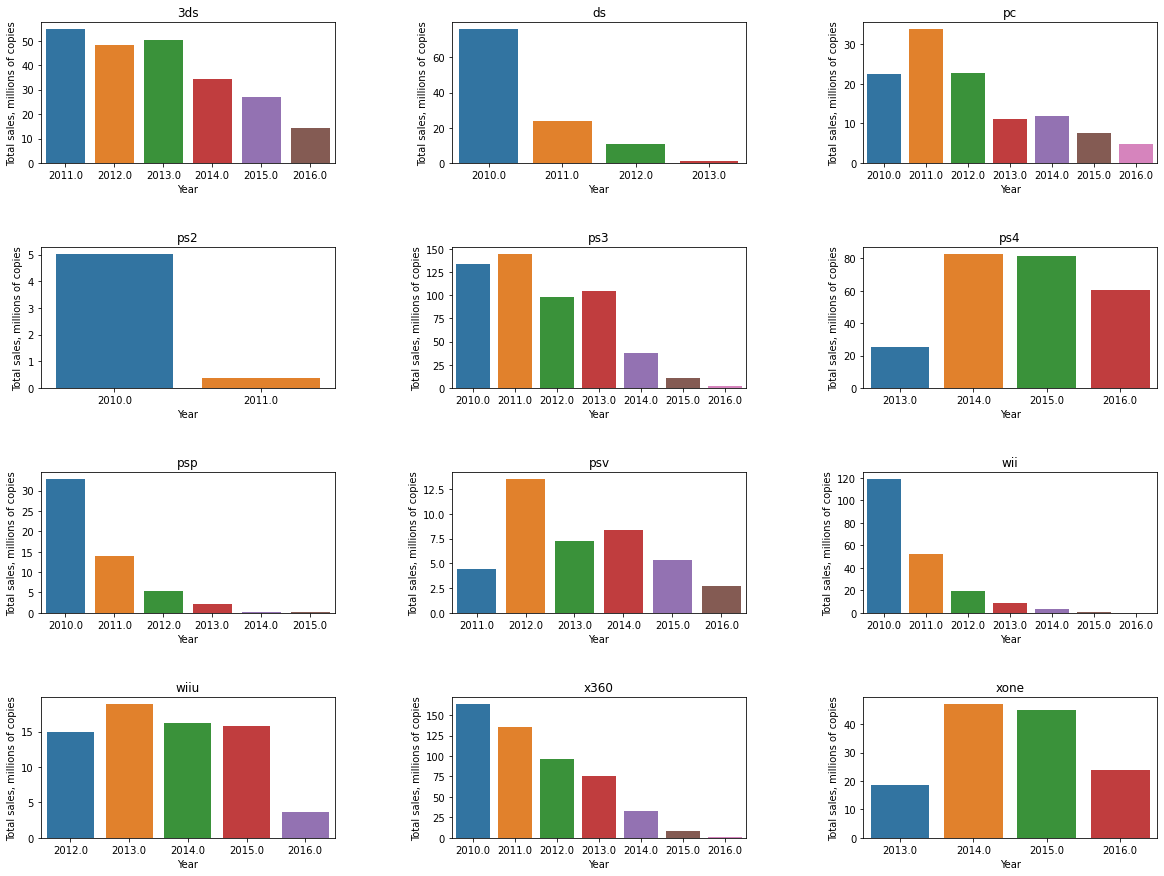

<Figure size 432x288 with 0 Axes>

In [53]:

a = 4  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.6, wspace=0.4)


for name in df_actual_gr['platform'].unique():
    plt.subplot(a, b, c)
    plt.title(name)
    ax = sns.barplot(x="year_of_release", y="total_sales",
                        data=df_actual_gr[df_actual_gr['platform'] == name])
    ax.set_xlabel('Year')
    ax.set_ylabel('Total sales, million copies')
    c = c + 1

plt.show()
plt.tight_layout()


    
    

Cumulative platform sales for 2016.

In [54]:
df.query('year_of_release == 2016').pivot_table(index = 'platform', 
                                                values = 'total_sales', 
                                                aggfunc = 'sum').reset_index()\
    .sort_values(by = 'total_sales', ascending = False)

,platform,total_sales
3,ps4,60.250000
8,xone,23.750000
0,3ds,14.164062
1,pc,4.890625
6,wiiu,3.589844
4,psv,2.720703
2,ps3,2.109375
7,x360,1.490234
5,wii,0.179932


Based on the graphs, we can see that there are no platforms that would have had a peak in sales in 2016. Therefore, we should take those platforms where in 2016 the level of sales was at a relatively high level, and also there was no strong decline in sales.

Out of the 12 top-selling platforms since 2012, PS4, XOne, 3DS, PSV and WiiU were chosen as potentially profitable platforms. As for PC, although it showed high sales in 2016, for it there is a strong decline in sales.

In [55]:
five = ['3ds', 'ps4', 'psv', 'wiiu', 'xone']
df_five = df_actual.query('platform in @five')

Boxplots for total sales values:

Text(0.5, 0, 'Platform')

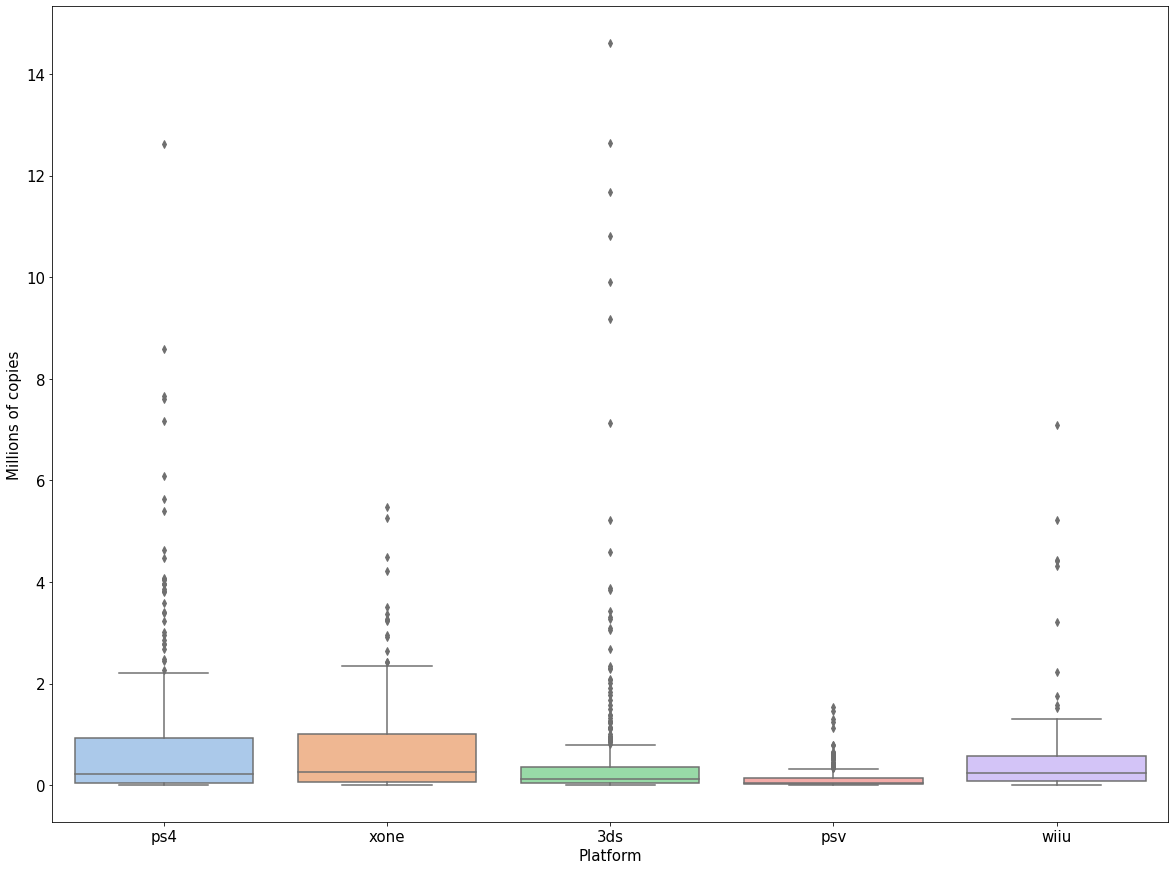

In [56]:
plt.figure(figsize=(20,15))
ax = sns.boxplot(x = 'platform', y="total_sales", 
               data=df_five, palette = 'pastel')
ax.tick_params(labelsize = 15)
plt.ylabel('million copies', fontsize=15)
plt.xlabel('Platform', fontsize=15)

For all the platforms there are outliers having very high sales compared to the rest. These outliers could also negatively affect the graphs we were using to chose potentially profitable platforms. However to remove these outliers is not correct, because they represent games which were poplular in the market and most probably will have some weight in the future, thus affecting platforms popularity. 

Also, platforms 3DS and PS4 have more games, showing very high sales, and this fact move the mean, affecting their popularity and profitability.



The difference between platforms is influenced by many factors. For example, some platforms are cheaper than others. 

Alternatively, if the platform is a continuation of a similar predecessor of the same brand, customers will tend to buy a new version for platforms they already have. Also, the differences can be influenced by certain unique characteristics of the platform and the advertising campaign.



**Now let's see how user and critics reviews affect sales within one popular platform.**
To do this, we will build scatter diagrams within platforms using data of critic_score and user_score columns and a column with sales data.
1. Impact of Critics Scores on game sales.

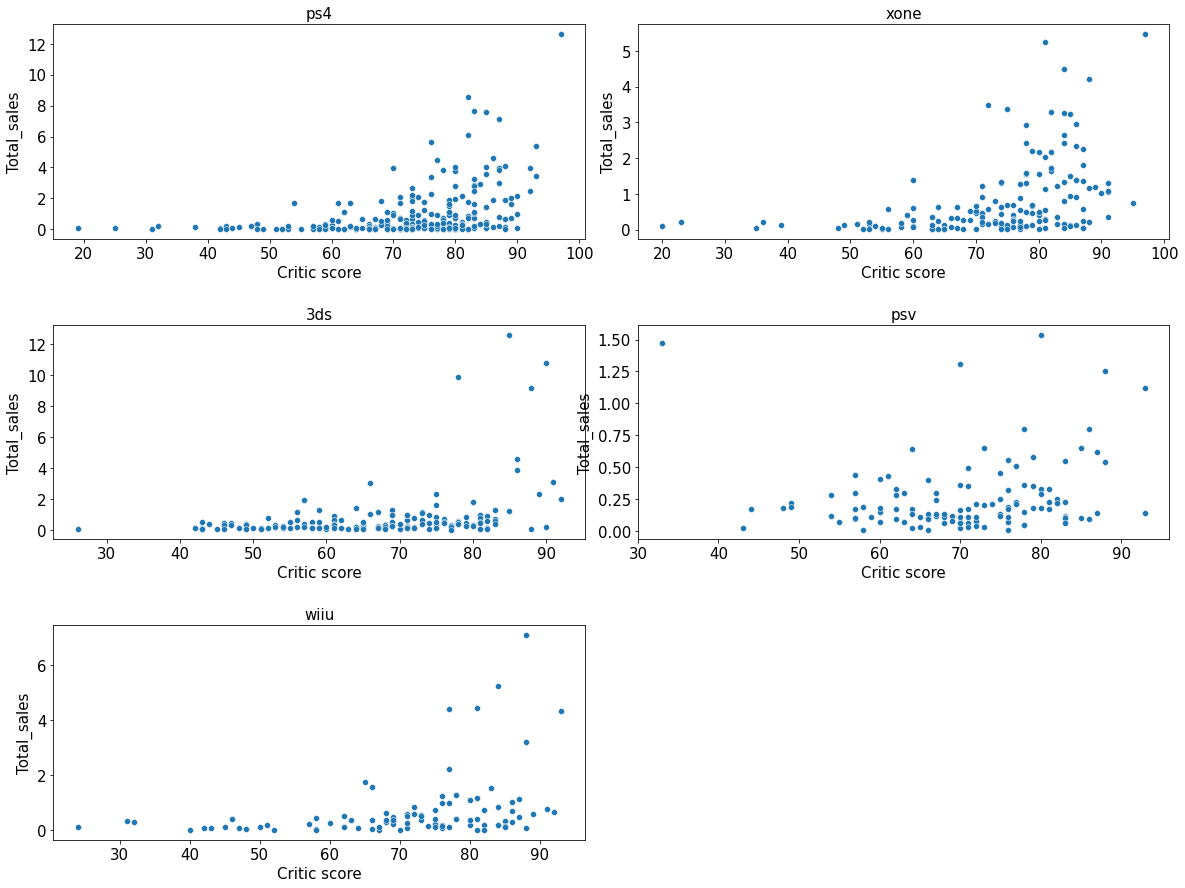

<Figure size 432x288 with 0 Axes>

In [57]:
a = 3  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for name in df_five['platform'].unique():
    df_five.sort_values(by = 'critic_score')
    plt.subplot(a, b, c)
    plt.title(name, fontsize=15)
    ax = sns.scatterplot(x="critic_score", y="total_sales",
               data=df_five[df_five['platform'] == name])
    ax.tick_params(labelsize = 15)
    plt.xlabel('Critic score', fontsize=15)
    plt.ylabel('Total_sales', fontsize=15)
    c = c + 1

plt.show()
plt.tight_layout()


2. Impact of Users Scores on game sales.

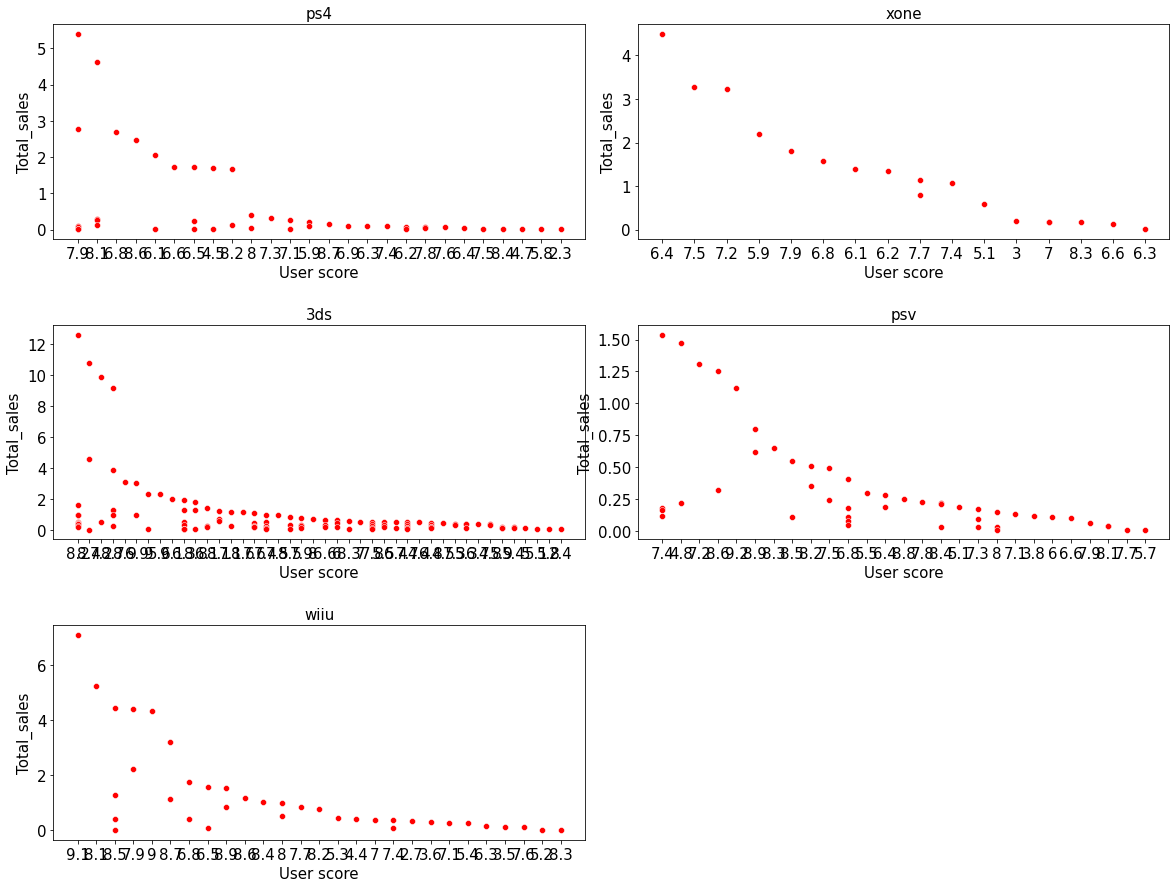

<Figure size 432x288 with 0 Axes>

In [58]:
a = 3  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for name in df_five['platform'].unique():
    df_five.sort_values(by = 'user_score')
    plt.subplot(a, b, c)
    plt.title(name, fontsize=15)
    ax = sns.scatterplot(x="user_score", y="total_sales",
               data=df_five[df_five['platform'] == name], color = 'red')
    ax.tick_params(labelsize = 15)
    plt.xlabel('User score', fontsize=15)
    plt.ylabel('Total_sales', fontsize=15)
    c = c + 1

plt.show()
plt.tight_layout()

For some platforms, critics reviews, as well as user reviews slightly positively affect the sales of the games. Let's look at the correlation for these factors and draw conclusions.

In [59]:
corr_df_five = df_five[['platform', 'critic_score', 'user_score', 'total_sales']]
for name in corr_df_five['platform'].unique():
    print(name, ':')
    display(corr_df_five[corr_df_five['platform'] == name].corr())

ps4 :


,critic_score,total_sales
critic_score,1.000000,0.403808
total_sales,0.403808,1.000000


xone :


,critic_score,total_sales
critic_score,1.000000,0.412046
total_sales,0.412046,1.000000


3ds :


,critic_score,total_sales
critic_score,1.000000,0.348744
total_sales,0.348744,1.000000


psv :


,critic_score,total_sales
critic_score,1.000000,0.131781
total_sales,0.131781,1.000000


wiiu :


,critic_score,total_sales
critic_score,1.00000,0.34833
total_sales,0.34833,1.00000


Take into account total number of games in the platforms:

In [60]:
df_five.pivot_table(index = 'platform', values = 'name', aggfunc = 'count')

,name
platform,
3ds,453
ps4,283
psv,324
wiiu,115
xone,190


So, based on the correlation tables, we see that for all platforms except Wi U, critics reviews have a greater effect on game sales compared to user reviews. Critics reviews correlate positively with game sales across all platforms, but the correlation is weak (or very weak in the case of the PSV platform). User reviews do not have any impact on the sales of games for PS Vita, PS4 and Xbox One platforms, have a very weak and weak effect on this indicator for the 3DS platform and positively but weakly correlate with sales of games on the Wii U platform, respectively.

One can assume that the popularity of the platform in general influences the correlation between sales and user reviews. For example, Wii U is not the most popular platform, its assortment of games is the smallest, and it has the highest correlation value with the sales. On the contrary, the Xbox One and PS4 platforms are quite popular, and there is no correlation between user reviews and sales. However, this indicator can be influenced by other factors, for example, the year of release or the success of the predecessor, etc.

**Then, let's look at the overall distribution of games by genre.** 

What we can say about the most profitable genres? Do high and low selling genres stand out?

In [61]:
df_five_genre = df_five.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum').reset_index()
df_five_genre.sort_values(by = 'total_sales', ascending = False).reset_index(drop = True)

,genre,total_sales
0,Action,189.500000
1,Shooter,122.937500
2,Role-Playing,117.687500
3,Sports,92.437500
4,Platform,61.250000
5,Racing,40.500000
6,Misc,31.843750
7,Simulation,28.078125
8,Fighting,15.593750
9,Adventure,12.742188


In [62]:
(df_five_genre[df_five_genre['genre'] == 'Action']['total_sales'])/ df_five_genre['total_sales'].sum()

0    0.261963
Name: total_sales, dtype: float16

In [63]:
(df_five_genre[df_five_genre['genre'] == 'Shooter']['total_sales'])/ df_five_genre['total_sales'].sum()

8    0.169922
Name: total_sales, dtype: float16

In [64]:
(df_five_genre[df_five_genre['genre'] == 'Role-Playing']['total_sales'])/ df_five_genre['total_sales'].sum()

7    0.16272
Name: total_sales, dtype: float16

In [65]:
(df_five_genre[df_five_genre['genre'] == 'Sports']['total_sales'])/ df_five_genre['total_sales'].sum()

10    0.127808
Name: total_sales, dtype: float16

In [66]:
(df_five_genre[df_five_genre['genre'] == 'Platform']['total_sales'])/ df_five_genre['total_sales'].sum()

4    0.084656
Name: total_sales, dtype: float16

The most popular genre is Action. Sales of games with this genre are about 35% higher compared to the second genre on the list - Shooter. Overall, action games (26.19%), shooters (16.99%), role (16.27%), and sport games (12.78%) are the most popular and have the most sales.

From the least popular, we single out games of Strategy, Puzzle, Adventure and Fighting genres.

## Castomer portrait<a id='customerid'></a>
### Popular platforms<a id='platformsid'></a>


New pivot table containing the information about sales of games on different platforms depending on the region:

In [67]:
df_sales_regions = df.pivot_table(index = 'platform', 
                                       values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'], 
                                       aggfunc = 'sum').reset_index()
df_sales_regions

,platform,eu_sales,jp_sales,na_sales,other_sales,total_sales
0,3do,0.000000,0.099976,0.000000,0.000000,0.099976
1,3ds,54.093750,90.437500,72.625000,11.640625,228.750000
2,dc,1.179688,7.628906,4.328125,0.190063,13.328125
3,ds,172.250000,170.250000,356.250000,54.687500,753.500000
4,gb,30.046875,51.843750,47.906250,4.710938,134.500000
5,gba,68.875000,44.125000,168.250000,6.890625,288.250000
6,gc,36.062500,19.843750,124.437500,4.871094,185.250000
7,gen,0.899902,1.320312,2.259766,0.189941,4.671875
8,n64,27.687500,27.937500,92.000000,3.269531,150.875000
9,nes,0.439941,1.279297,1.940430,0.059998,3.720703


In [68]:
df_sales_regions.columns

Index(['platform', 'eu_sales', 'jp_sales', 'na_sales', 'other_sales',
       'total_sales'],
      dtype='object')

Let's add columns with the percentage of total sales:

In [69]:
lambdafunc = lambda x: pd.Series(["{:.2f}".format(x['eu_sales']/x['total_sales']*100),
                                  "{:.2f}".format(x['jp_sales']/x['total_sales']*100),
                                  "{:.2f}".format(x['na_sales']/x['total_sales']*100),
                                  "{:.2f}".format(x['other_sales']/x['total_sales']*100)])
df_sales_regions[['eu_per', 'jp_per', 'na_per', 'other_per']] = df_sales_regions.apply(lambdafunc, axis=1)
df_sales_regions = df_sales_regions.sort_values(by = 'total_sales', ascending = False).reset_index(drop = True)
df_sales_regions

,platform,eu_sales,jp_sales,na_sales,other_sales,total_sales,eu_per,jp_per,na_per,other_per
0,ps2,312.000000,126.250000,548.000000,176.500000,1163.000000,26.83,10.86,47.12,15.18
1,x360,249.875000,11.351562,568.500000,80.250000,910.000000,27.46,1.25,62.47,8.82
2,ps3,301.000000,66.625000,371.000000,125.125000,863.500000,34.86,7.72,42.96,14.49
3,wii,240.000000,64.500000,457.000000,72.562500,834.000000,28.78,7.73,54.80,8.70
4,ds,172.250000,170.250000,356.250000,54.687500,753.500000,22.86,22.59,47.28,7.26
5,ps,180.375000,122.125000,272.000000,34.562500,609.000000,29.62,20.05,44.66,5.68
6,gba,68.875000,44.125000,168.250000,6.890625,288.250000,23.89,15.31,58.37,2.39
7,psp,61.250000,66.875000,102.437500,38.312500,269.000000,22.77,24.86,38.08,14.24
8,ps4,114.437500,10.367188,86.000000,38.593750,249.375000,45.89,4.16,34.49,15.48
9,xb,56.281250,1.370117,172.875000,7.992188,238.500000,23.60,0.57,72.48,3.35


5 platforms (ng, ws, tg16, 3do, pcfx) exist only in Japan.

Then let's determine 5 most popular platforms for each of the regions:

In [70]:
top_eu = df_sales_regions.sort_values(by = 'eu_sales', ascending = False).head()
top_na = df_sales_regions.sort_values(by = 'na_sales', ascending = False).head()
top_jp = df_sales_regions.sort_values(by = 'jp_sales', ascending = False).head()
display(top_eu[['platform', 'eu_sales', 'jp_sales', 'na_sales', 'eu_per', 'jp_per', 'na_per']], 
        top_jp[['platform', 'eu_sales', 'jp_sales', 'na_sales', 'eu_per', 'jp_per', 'na_per']], 
        top_na[['platform', 'eu_sales', 'jp_sales', 'na_sales', 'eu_per', 'jp_per', 'na_per']])

,platform,eu_sales,jp_sales,na_sales,eu_per,jp_per,na_per
0,ps2,312.000,126.250000,548.0,26.83,10.86,47.12
2,ps3,301.000,66.625000,371.0,34.86,7.72,42.96
1,x360,249.875,11.351562,568.5,27.46,1.25,62.47
3,wii,240.000,64.500000,457.0,28.78,7.73,54.80
5,ps,180.375,122.125000,272.0,29.62,20.05,44.66


,platform,eu_sales,jp_sales,na_sales,eu_per,jp_per,na_per
4,ds,172.25000,170.2500,356.25000,22.86,22.59,47.28
0,ps2,312.00000,126.2500,548.00000,26.83,10.86,47.12
5,ps,180.37500,122.1250,272.00000,29.62,20.05,44.66
10,3ds,54.09375,90.4375,72.62500,23.65,39.54,31.75
16,snes,5.53125,66.8750,17.84375,6.07,73.39,19.58


,platform,eu_sales,jp_sales,na_sales,eu_per,jp_per,na_per
1,x360,249.875,11.351562,568.50,27.46,1.25,62.47
0,ps2,312.000,126.250000,548.00,26.83,10.86,47.12
3,wii,240.000,64.500000,457.00,28.78,7.73,54.80
2,ps3,301.000,66.625000,371.00,34.86,7.72,42.96
4,ds,172.250,170.250000,356.25,22.86,22.59,47.28


The most popular platforms in Europe: ps2, ps3, x360, wii, **ps**.

The most popular platforms in North America: x360, ps2, wii, ps3, **ds**.

The most popular platforms in Japan: ds, ps2, ps, 3ds, psp.

As we see, 4 of the most populat platforms in Europe and NA are the same. However, the list of popular platforms is different in Japan: the most poplula platform is DS, which takes only the 5th position in NA and is abscent in the top-5 plaforms in Europe. Alsom there are two plattforms in Japan, 3DS and PSP, which are not present in top-5 list of NA or Europe. Platform PS2 can be considered as the most poplular overall.

The sales rates demonstrate higher games sales in NA compared to Europe or Japan, and account for about half of all sales on top platforms. Platforms 3DS and PSP, top-ranked in Japan, have 40% lower sales rates in NA in comparison to Japan, which highlights the popularity of the former in Japan, taking into consideration the sizes of the countries. A similar conclusion can be drawn about the ps2 platform in Europe.



### Poplular genres<a id='genresid'></a>
Pivot table for genres and sales in different regions:

In [71]:
df_genres = df.pivot_table(index = 'genre', 
                           values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'], 
                           aggfunc = 'sum').reset_index()


Adding columns with the percent of total sales:

In [72]:
lambdafunc = lambda x: pd.Series(["{:.2f}".format(x['eu_sales']/x['total_sales']*100),
                                  "{:.2f}".format(x['jp_sales']/x['total_sales']*100),
                                  "{:.2f}".format(x['na_sales']/x['total_sales']*100),
                                  "{:.2f}".format(x['other_sales']/x['total_sales']*100)])
df_genres[['eu_per', 'jp_per', 'na_per', 'other_per']] = df_genres.apply(lambdafunc, axis=1)
df_genres = df_genres.sort_values(by = 'total_sales', ascending = False).reset_index(drop = True)
df_genres

,genre,eu_sales,jp_sales,na_sales,other_sales,total_sales,eu_per,jp_per,na_per,other_per
0,Action,447.50000,130.125000,722.50000,165.875000,1466.000,30.53,8.88,49.28,11.31
1,Sports,327.50000,94.562500,606.50000,119.125000,1148.000,28.53,8.24,52.83,10.38
2,Shooter,285.00000,30.453125,497.50000,94.437500,907.500,31.40,3.36,54.82,10.41
3,Role-Playing,180.00000,287.250000,316.75000,54.187500,838.000,21.48,34.28,37.80,6.47
4,Misc,187.25000,96.500000,357.00000,63.656250,704.500,26.58,13.70,50.67,9.04
5,Racing,209.25000,45.750000,315.75000,68.812500,639.500,32.72,7.15,49.37,10.76
6,Platform,153.50000,75.875000,289.75000,42.093750,561.000,27.36,13.52,51.65,7.50
7,Simulation,108.25000,58.718750,171.25000,29.468750,367.750,29.44,15.97,46.57,8.01
8,Fighting,81.81250,65.625000,177.12500,31.375000,356.000,22.98,18.43,49.75,8.81
9,Adventure,50.00000,40.375000,83.93750,14.171875,188.500,26.53,21.42,44.53,7.52


In North America, sales are about double.

Let's take a look at the 5 most popular genres for each region: Europe, North America, Japan.

In [73]:
topg_eu = df_genres.sort_values(by = 'eu_sales', ascending = False).head().reset_index(drop = True)
topg_na = df_genres.sort_values(by = 'na_sales', ascending = False).head().reset_index(drop = True)
topg_jp = df_genres.sort_values(by = 'jp_sales', ascending = False).head().reset_index(drop = True)
display(topg_eu, topg_na, topg_jp)

,genre,eu_sales,jp_sales,na_sales,other_sales,total_sales,eu_per,jp_per,na_per,other_per
0,Action,447.50,130.125000,722.50,165.87500,1466.0,30.53,8.88,49.28,11.31
1,Sports,327.50,94.562500,606.50,119.12500,1148.0,28.53,8.24,52.83,10.38
2,Shooter,285.00,30.453125,497.50,94.43750,907.5,31.40,3.36,54.82,10.41
3,Racing,209.25,45.750000,315.75,68.81250,639.5,32.72,7.15,49.37,10.76
4,Misc,187.25,96.500000,357.00,63.65625,704.5,26.58,13.70,50.67,9.04


,genre,eu_sales,jp_sales,na_sales,other_sales,total_sales,eu_per,jp_per,na_per,other_per
0,Action,447.50,130.125000,722.50,165.87500,1466.0,30.53,8.88,49.28,11.31
1,Sports,327.50,94.562500,606.50,119.12500,1148.0,28.53,8.24,52.83,10.38
2,Shooter,285.00,30.453125,497.50,94.43750,907.5,31.40,3.36,54.82,10.41
3,Misc,187.25,96.500000,357.00,63.65625,704.5,26.58,13.70,50.67,9.04
4,Role-Playing,180.00,287.250000,316.75,54.18750,838.0,21.48,34.28,37.80,6.47


,genre,eu_sales,jp_sales,na_sales,other_sales,total_sales,eu_per,jp_per,na_per,other_per
0,Role-Playing,180.00,287.2500,316.75,54.18750,838.0,21.48,34.28,37.80,6.47
1,Action,447.50,130.1250,722.50,165.87500,1466.0,30.53,8.88,49.28,11.31
2,Misc,187.25,96.5000,357.00,63.65625,704.5,26.58,13.70,50.67,9.04
3,Sports,327.50,94.5625,606.50,119.12500,1148.0,28.53,8.24,52.83,10.38
4,Platform,153.50,75.8750,289.75,42.09375,561.0,27.36,13.52,51.65,7.50


Build a table for data vizualization:


In [74]:
genre_vis = df_genres[['genre', 'eu_sales', 'na_sales', 'jp_sales', 'other_sales']]
genre_vis

,genre,eu_sales,na_sales,jp_sales,other_sales
0,Action,447.50000,722.50000,130.125000,165.875000
1,Sports,327.50000,606.50000,94.562500,119.125000
2,Shooter,285.00000,497.50000,30.453125,94.437500
3,Role-Playing,180.00000,316.75000,287.250000,54.187500
4,Misc,187.25000,357.00000,96.500000,63.656250
5,Racing,209.25000,315.75000,45.750000,68.812500
6,Platform,153.50000,289.75000,75.875000,42.093750
7,Simulation,108.25000,171.25000,58.718750,29.468750
8,Fighting,81.81250,177.12500,65.625000,31.375000
9,Adventure,50.00000,83.93750,40.375000,14.171875


In [75]:
#change columns and indexes
df_t = genre_vis.T.reset_index()

In [76]:
d = {'index':'genre', 0:'Action', 1:'Sports', 2:'Shooter', 3:'Role-Playing', 
    4:'Misc', 5:'Racing', 6:'Platform', 7:'Simulation',
    8:'Fighting', 9:'Adventure', 10:'Strategy', 11:'Puzzle'}
df_t.rename(columns = d, inplace = True)
df_t = df_t.loc[1:]
df_t

,genre,Action,Sports,Shooter,Role-Playing,Misc,Racing,Platform,Simulation,Fighting,Adventure,Strategy,Puzzle
1,eu_sales,447.5,327.5,285.0,180.0,187.25,209.25,153.5,108.25,81.8125,50.0,40.71875,41.78125
2,na_sales,722.5,606.5,497.5,316.75,357.0,315.75,289.75,171.25,177.125,83.9375,63.78125,69.875
3,jp_sales,130.125,94.5625,30.453125,287.25,96.5,45.75,75.875,58.71875,65.625,40.375,43.4375,35.6875
4,other_sales,165.875,119.125,94.4375,54.1875,63.65625,68.8125,42.09375,29.46875,31.375,14.171875,10.171875,10.609375


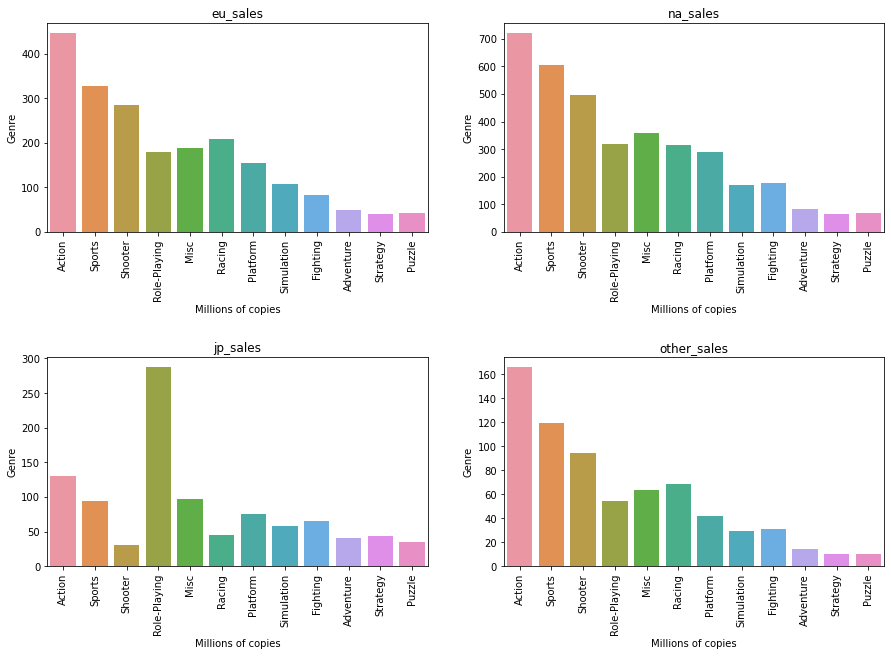

<Figure size 432x288 with 0 Axes>

In [77]:
#plot
a = 2  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.6, wspace=0.2)


for name in df_t['genre'].unique():
    plt.subplot(a, b, c)
    plt.title(name)
    ax = sns.barplot(data=df_t[df_t['genre'] == name])
    ax.set_xlabel('million copies')
    ax.set_ylabel('Genre')
    plt.xticks(rotation=90)
    c = c + 1

plt.show()
plt.tight_layout()

The most populat genres:
* **Europe:** Action, Sports, Shooter, Racing, Misc.
* **North America:** Action, Sports, Shooter, Misc, Role-playing.
* **Japan:** Role-playing, Action, Misc, Sports, Platform. 

In general, in NA and Europe, 4 out of 5 top genres are the same. In NA, role-playing games are in the top 5 genres list, and in Europe this is racing genre. It is noticable looking at the plots above, that the distribution in EU and NA is similar, meanwhile Japan people have completely different genre preferences. The most popular genre in Japan is RPG, which is only the fifth in NA and is not included in the list of the top five genres in Europe. There is also the Platform genre, which ranks 7th in North America and Europe. The differences between Japan and the United States and Europe can be explained by the huge difference in culture and mentality.




### ESRB rating<a id='ersbid'></a>

**Let's see if ESRB rating affects the sales in different regions.**

Substitute NaN values of rating_age column with 'unknown':


In [78]:
df['rating_age'].fillna('unknown', inplace = True)

Group our data by rating:

In [79]:
ersb = df.pivot_table(index = 'rating_age', values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'], 
                      aggfunc = 'sum').reset_index()
ersb = ersb.sort_values(by = 'total_sales',ascending = False)
ersb

,rating_age,eu_sales,jp_sales,na_sales,other_sales,total_sales
1,E,704.000000,198.000000,1273.000000,231.375000,2406.000000
8,unknown,323.500000,550.500000,557.500000,71.375000,1502.000000
7,T,421.000000,150.750000,747.500000,153.000000,1472.000000
5,M,480.000000,63.593750,743.000000,176.125000,1462.000000
2,E10+,183.375000,40.187500,345.500000,71.937500,641.000000
4,K-A,0.270020,1.459961,2.560547,0.029999,4.320312
0,AO,0.609863,0.000000,1.259766,0.090027,1.958984
3,EC,0.110046,0.000000,1.530273,0.109985,1.750000
6,RP,0.029999,0.000000,0.000000,0.010002,0.040009


In [80]:
ersb_t = ersb.T.reset_index()
ersb_t

,index,1,8,7,5,2,4,0,3,6
0,rating_age,E,unknown,T,M,E10+,K-A,AO,EC,RP
1,eu_sales,704.0,323.5,421.0,480.0,183.375,0.27002,0.609863,0.110046,0.029999
2,jp_sales,198.0,550.5,150.75,63.59375,40.1875,1.459961,0.0,0.0,0.0
3,na_sales,1273.0,557.5,747.5,743.0,345.5,2.560547,1.259766,1.530273,0.0
4,other_sales,231.375,71.375,153.0,176.125,71.9375,0.029999,0.090027,0.109985,0.010002
5,total_sales,2406.0,1502.0,1472.0,1462.0,641.0,4.320312,1.958984,1.75,0.040009


In [81]:
d = {'index':'ERSB', 0:'AO', 1:'E', 2:'E10+', 3:'EC', 
    4:'K-A', 5:'M', 6:'RP', 7:'T',
    8:'unknown'}
ersb_t.rename(columns = d, inplace = True)
ersb_t = ersb_t.loc[1:4]
ersb_t

,ERSB,E,unknown,T,M,E10+,K-A,AO,EC,RP
1,eu_sales,704.0,323.5,421.0,480.0,183.375,0.27002,0.609863,0.110046,0.029999
2,jp_sales,198.0,550.5,150.75,63.59375,40.1875,1.459961,0.0,0.0,0.0
3,na_sales,1273.0,557.5,747.5,743.0,345.5,2.560547,1.259766,1.530273,0.0
4,other_sales,231.375,71.375,153.0,176.125,71.9375,0.029999,0.090027,0.109985,0.010002


Plot the ERB rating information for different regions:

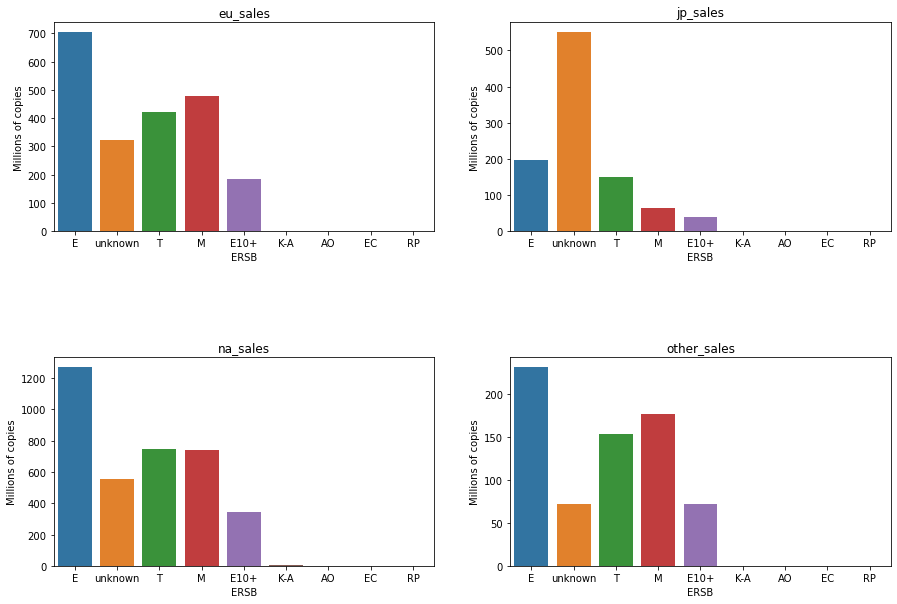

<Figure size 432x288 with 0 Axes>

In [82]:
a = 2  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.6, wspace=0.2)


for name in ersb_t['ERSB'].unique():
    plt.subplot(a, b, c)
    plt.title(name)
    ax = sns.barplot(data=ersb_t[ersb_t['ERSB'] == name])
    ax.set_xlabel('ERSB')
    ax.set_ylabel('million copies')
    
    c = c + 1

plt.show()
plt.tight_layout()

There are four prevailing age categories (E, T, M, E10+): 
* «E» - («Everyone»);
* «T» - («Teen»);
* «M» - («Mature»);
* «E10+» -  («Everyone 10 and older»);

Other categories:
* «AO» («Adults Only 18+»);
* «RP» («Rating Pending»);
* «EC» («Early childhood»);
* "K-A" ("Kids to Adults");

So:
* In all the regions, games for all ages («E») account for the largest number of sales.
* In **Japan** games for teenagers are more popular than games for adults and for people over 10 years old. 
* In **Europe** games for adults come second, followed by games for teenagers, and games for everyone over 10 are in fourth place.
* In **North America** games for teens and adults are equally popular, while games in the E + 10 category are less popular. 
* There are a lot of missing values in the raw data for games in Japan.

## Hypothesis testing<a id='hypothesisid'></a>



Let's investigate:
1. Whether the average user ratings for the Xbox One and PC platforms are the same.
2. Do the average user ratings for the Action and Sports genres differ.

To carry out the Student's t-test, we use the method **st.ttest_ind()**. Our goal is to establish the difference between the two datasets (samples).

In [83]:
user_scores = df_actual.pivot_table(index = 'platform', values = 'user_score').reset_index()
user_scores.query('platform == "xone" or  platform == "pc"')

C:\Python\anaconda\lib\site-packages\pandas\core\apply.py:507: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  return self._try_aggregate_string_function(obj, f, *self.args, **self.kwargs)


,platform
2,pc
11,xone


In order to test whether the average user ratings of the Xbox One and PC platforms are the same, we set the null and alternative hypotheses:
* H${0}$: the average user ratings of the two platforms are the same.
* H${A}$: the average user ratings of the two platforms are different.


Significance level: 95%.


In [84]:
pc = df_actual.loc[df['platform'] == 'pc']['user_score'].dropna().astype('float')
xone = df_actual.loc[df['platform'] == 'xone']['user_score'].dropna().astype('float')

In [85]:
result = st.ttest_ind(pc, xone, nan_policy = 'omit') #
alpha = 0.05
print('p-value: ', result.pvalue)
if result.pvalue < alpha:
    print("Rejecting the Null Hypothesis: Average User Ratings for Xbox One and PC Platforms Differ")
else:
    print("Unable to reject the null hypothesis: Average User Ratings for the Xbox One and PC platforms are the same")

p-value:  0.8730524887918734
Unable to reject the null hypothesis: Average User Ratings for the Xbox One and PC platforms are the same


Student's t-test results indicate that there is no statistically significant difference between the user ratings of the Xbox One and PC platforms.

Let's look at the data on the Action and Sports genres:

In [86]:
two_genres = df_actual.pivot_table(index = 'genre', values = 'user_score').reset_index()
two_genres.query('genre == "Action" or  genre == "Sports"')

C:\Python\anaconda\lib\site-packages\pandas\core\apply.py:507: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  return self._try_aggregate_string_function(obj, f, *self.args, **self.kwargs)


,genre
0,Action
10,Sports


In order to test whether the average user scores of the Action and Sports genres differ, we set the null and alternative hypotheses:
* H${0}$: the average user scores of the two genres are the same.
* H${A}$: the average user scores of the two genres are different.

α = 0.95.

In [88]:
action = df_actual.loc[df['genre'] == 'Action']['user_score'].dropna().astype('float')
sports = df_actual.loc[df['genre'] == 'Sports']['user_score'].dropna().astype('float')
result = st.ttest_ind(action, sports, nan_policy = 'omit')
alpha = 0.05
print('p-значение: ', result.pvalue)
if result.pvalue < alpha:
    print("Rejecting the null hypothesis: average user scores for Action and Sports are different")
else:
    print("Failed to reject the null hypothesis: the average user scores for the Action and Sports genres are the same")

p-значение:  0.0025857101164219478
Rejecting the null hypothesis: average user scores for Action and Sports are different


Student's t-test results indicate that user scores for the Action and Sports genres differ. Thus, the rating of the Action genre is higher than the Sports genre. 

## Conclusions<a id='conclusionid'></a>

1. In the course of this work, we analyzed data on sales and ratings of computer games around the world in order to identify potentially popular games and plan an advertising campaign for 2017.

2. From 1994 to the present, different platforms have had varying popularity. On average, new platforms appear and disappear over a period of about 10 years. Sales peak is usually comes after 1-6 years since the appearance of the game, depending on the platform and, probably, the advertising campaigns carried out.

3. Since 2010, 12 platforms have been introduced to the global market. Out of them, Play Station 4 (PS4), Xbox One, 3DS, PS Vita and Wii U had the highest sales rates in 2016 and showed the smallest sales declines: 
* PS4 - 60.25 million copies;
* Xbox One - 23.75 million copies;
* 3DS - 14.16 million copies;
* PS Vita - 2.72 million copies;
* Wii U - 3.58 million copies;

Platforms PS Vita, 3DS and PS4 had very high sales in general, which makes these platforms the most profitable. 


4. Both ** critics reviews ** and ** user reviews ** have a weak positive impact on game sales on PS4, Xbox One, 3DS, PS Vita and Wii U platforms. In the same time, for all platforms except Wii U, critics reviews have a greater effect on game sales than user reviews. 


5. For PS4, Xbox One, 3DS, PS Vita and Wii U platforms, the most popular genres are Action (26%), Shooter (17%), Role-Playing (16%), Sports (13%) and Platform (8%). The least popular are Strategy and Puzzle.


6. **User portrait** was compiled for each region.


* The most popular platforms:

In **Europe**  PS2, PS2, Xbox 360, Wii, PS. 

In **North America** - Xbox360, PS2, Wii, PS3, DS. 

In **Japan** - DS, PS2, PS, 3DS, PSP. 

PS2 can be chosen as the most popular in general. 
* In general, games sales in the United States are much higher than in Europe and Japan.
* Most popular genres: 

In **Europe**: Action, Sports, Shooter, Races, Misc.


In **North America**: Action, Sports, Shooter, Misc, Role_Playing.


In **Japan**: Role_Playing, Action, Misc, Sports, Platform.

* Among all the **age categories**, there are four most popular ones (E, T, M, E10+), games within these categories have the highest sales.

«E» - («Everyone»);


«T» - («Teen»);


«M» - («Mature»);


«E10+» - («Everyone 10 and older»);

"E" category is the most popular in all the regions.


In **Japan** games for teenagers are more popular than games for adults and for people over 10 years old.


In **Europe** games for adults come second, followed by games for teenagers, and games for everyone over 10 are in the fourth place.


In **North America** games for teens and adults are equally popular, while games in the E + 10 category are less popular.

7. **Statistical analysis of the data** was carried out:

a) user scores for games on PC and Xbox One do not differ statistically.

b) User scores for the Action and Sports genres are statistically different. The Action genre (6.8) has a higher rating than the Sports genre (5.8).

**General conclusion:** 

Advertising campaigns should be planned differently for each region, based on the shown results . In 2017, the focus should be on promoting platforms: PS4, Xbox One, 3DS, PS Vita and Wii U.

**Suggestion:** In addition, it would be interesting to analyze outliers in PS4, Xbox One, 3DS, PS Vita and Wii U platforms to find the most popular games in different regions.